# Setup

In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from helper_functions import *

import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from mne.stats import fdr_correction

curr_dir = mkdirifnotexists(os.path.join('specific_mb-metabolite_pathway'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [20]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')
pnp_data = pnp_data[pnp_data.IsGenotek == 0]
pnp_data = pnp_data[pnp_data.Nextera == 'True']
acs_data['ACS sample'] = 1
pnp_data['ACS sample'] = 0

pnp_data_metabolon = pd.read_csv(os.path.join('data', 'pnp_data_metabolon_storage_residuals.csv'), index_col=0)
acs_data_metabolon = pd.read_csv(os.path.join('data', 'acs_data_metabolon_storage_residuals.csv'), index_col=0)
updated_metabs1 = pd.read_csv('additional_metabolon_files/updated_metabs1.csv', index_col=0)
circ_heatmap_df_sorted = pd.read_csv(os.path.join('serum_metabolomics_signatures', 'metabolon', 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0)
unknowns_sp = # Supplementary Table 2 from https://doi.org/10.1038/s41586-020-2896-2

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (43,3236) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (1,11,24,31,41,97,108,111,112,113,132,133,134,135,136,137,138,139,140,141,142,143,144,146,149,150,151,152,153,154,156,158,160,170,171,180,185,3213) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
storage_bad_metabs = pd.read_pickle(os.path.join('data', 'storage_time_bad_metabs_bonf.pkl'))

## MetaCardis

In [22]:
metacardis_dir = os.path.join('MetaCardis')
metacardis_X_path = os.path.join(metacardis_dir, 'dataframes', 'mb_diet_covariates_drugs_group.csv')
metacardis_metabolomics_path = os.path.join(metacardis_dir, 'metabolomics', 'robust_zs_metabolomics/proc_metabolomics_clipped.csv')
metacardis_X = pd.read_csv(metacardis_X_path, index_col=0)
metacardis_metadata_path = os.path.join(metacardis_dir, 'metabolomics', 'metadata', 'hub.metadata_reduced.samples.v10.r')
metacardis_X = metacardis_X.merge(pd.read_csv(metacardis_metadata_path, sep='\t', index_col=0)[['PATGROUPFINAL_C']], on='SampleID', how='left')
metacardis_X_age_bmi = metacardis_X[['AGE', 'BMI_C', 'Group']].copy()
metacardis_metabolomics = pd.read_csv(metacardis_metabolomics_path, index_col=0)
print (set([s.split('___')[0] for s in metacardis_metabolomics.columns]))
metacardis_serum_metabolomics = metacardis_metabolomics.loc[:, ['urine' not in s.split('___')[0] for s in metacardis_metabolomics.columns]].dropna()
# metacardis_serum_metabolomics = metacardis_metabolomics.filter(regex='hub.lipo.samples.v3.r')
full_index = list(set(metacardis_serum_metabolomics.index).intersection(set(metacardis_X_age_bmi.index)))
metacardis_serum_metabolomics, metacardis_X_age_bmi = metacardis_serum_metabolomics.loc[full_index].astype(float), metacardis_X_age_bmi.loc[full_index]
metacardis_serum_metabolomics.index.names = ['SampleID']
metacardis_X_age_bmi.Group.value_counts()

{'hub.serum_tmao.v1.samples.r', 'hub.lipo.samples.v3.r', 'hub.urine_annotated.samples.v2.r', 'hub.serum_absolute.v1.samples.r'}


IHD372     269
HC275      225
MMC269     188
UMCC222    159
Name: Group, dtype: int64

# bacteria-metabolite correlations

In [30]:
k = 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__unknown|s__unknown|fSGB__1439|gSGB__3527|sSGB__4712'
kp = pnp_data_metabolon.loc[:, list(set(circ_heatmap_df_sorted.index) - set(storage_bad_metabs))].astype(float)\
            .apply(lambda x: spearmanr(x, pnp_data_metabolon[k], nan_policy='omit')[1]).sort_values()
kr = pnp_data_metabolon.loc[:, list(set(circ_heatmap_df_sorted.index) - set(storage_bad_metabs))].astype(float)\
            .apply(lambda x: spearmanr(x, pnp_data_metabolon[k], nan_policy='omit')[0]).sort_values()

In [33]:
fdr_correction(kp, alpha=0.01)[0].sum()
used_metabs = kp[fdr_correction(kp, alpha=0.01)[0]].index
used_metabs

Index(['100006191', '100001315', 'X - 23997', '100000011', '100001417',
       'X - 11843', 'X - 11850', '100004318', '100000467', 'X - 21286',
       '100006260', 'X - 24473', '100002154', 'X - 11315', 'X - 12013'],
      dtype='object')

In [34]:
df_temp = pd.concat((updated_metabs1.loc[used_metabs, ['BIOCHEMICAL', 'SUB_PATHWAY']], 
               circ_heatmap_df_sorted.loc[used_metabs, 'Healthy-ACS'],
               kr.loc[used_metabs].rename('Correlation with bacteria')), axis=1)
df_temp['SUB_PATHWAY'].fillna(unknowns_sp.reindex(used_metabs).idxmax(1), inplace=True)
print (spearmanr(df_temp['Correlation with bacteria'], df_temp['Healthy-ACS']))
df_temp.to_csv(os.path.join(curr_dir, 'SGB4712_correlations.csv'))
df_temp

SpearmanrResult(correlation=-0.7178571428571427, pvalue=0.002581165308218854)


,BIOCHEMICAL,SUB_PATHWAY,Healthy-ACS,Correlation with bacteria
100006191,p-cresol-glucuronide*,Tyrosine Metabolism,2.706013,-0.326299
100001315,p-cresol sulfate,Benzoate Metabolism,0.719160,-0.303341
X - 23997,X - 23997,Benzoate Metabolism,2.004256,-0.264162
100000011,phenylacetate,Phenylalanine Metabolism,0.401433,-0.245824
100001417,phenylacetylglutamine,Acetylated Peptides,0.203488,-0.237588
X - 11843,X - 11843,Tryptophan Metabolism,0.624293,-0.236423
X - 11850,X - 11850,Tryptophan Metabolism,0.022319,-0.234963
100004318,indolin-2-one,Food Component/Plant,-0.293088,-0.225272
100000467,3-indoxyl sulfate,Tryptophan Metabolism,-0.313810,-0.217537
X - 21286,X - 21286,Tryptophan Metabolism,0.328052,-0.208005


In [30]:
mb_df = pd.concat((metacardis_X[[k, 'Group']].rename_axis('RegistrationCode'), 
                                matched_pnp_data[[k, 'ACS sample']],
                                matched_acs_data[[k, 'ACS sample']]), axis=0, sort=False)
#                                 pnp_data[[k, 'ACS sample']],
#                                 acs_data[[k, 'ACS sample']]), axis=0, sort=False)

mb_df['Group'].fillna(mb_df['ACS sample'], inplace=True)
mb_df['Group'].replace({'HC275':0, 'IHD372':1, 'MMC269':0.33, 'UMCC222':0.66}, inplace=True)
mb_df['ACS sample'] = ['MetaCardis' if pd.isnull(s) else 'Our cohort' for s in mb_df['ACS sample']]
mb_df.rename(columns={'ACS sample':'Cohort'}, inplace=True)

mb_df

,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__unknown|s__unknown|fSGB__1439|gSGB__3527|sSGB__4712,Group,Cohort
RegistrationCode,,,
x10MCx3300,0.003701,0.66,MetaCardis
x12MCx1639,0.000195,1.00,MetaCardis
x12MCx1893,0.000577,1.00,MetaCardis
x10MCx1668,0.000100,1.00,MetaCardis
x30MCx1902,0.000100,1.00,MetaCardis
...,...,...,...
3972217,0.000100,1.00,Our cohort
3437341,0.000100,1.00,Our cohort
3096233,0.000100,1.00,Our cohort


# Plot

## merge boxplots into supplementary

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0 1]
[0 1 2 3]


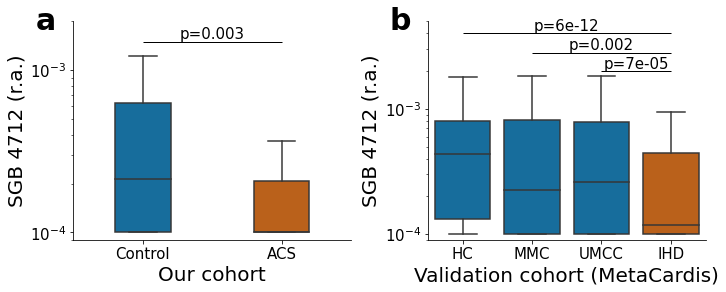

In [15]:
label_fontsize=20
tick_fontsize=15

fig, axes = plt.subplots(1, 2, figsize=(10, 4))


ax = axes[0]
sns.boxplot(x='Group', y=k, data=mb_df[mb_df.Cohort == 'Our cohort'].sort_values('Group'), ax=ax, showfliers=False, palette=[healthy_color, acs_color], width=0.4)
# ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD/ACS'])
ax.set_xticklabels(['Control', 'ACS'])
# plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
ax.set_yscale('log')
ax.set_ylabel('SGB 4712 (r.a.)', fontsize=label_fontsize)
ax.set_xlabel('Our cohort', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
ax.set_ylim((9e-5, 2e-3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print (ax.get_xticks())

t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 0)][k])
xx=0.5
ax.text(xx, 0.0015,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.0015, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')

ax = axes[1]
sns.boxplot(x='Group', y=k, data=mb_df[mb_df.Cohort == 'MetaCardis'].sort_values('Group'), ax=ax, showfliers=False, palette=[healthy_color, healthy_color, healthy_color, acs_color])
ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD'])
# ax.set_xticklabels(['Healthy', 'ACS'])
# plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
ax.set_yscale('log')
ax.set_ylabel('SGB 4712 (r.a.)', fontsize=label_fontsize)
ax.set_xlabel('Validation cohort (MetaCardis)', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
ax.set_ylim((9e-5, 5e-3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print (ax.get_xticks())

t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.66)][k])
xx=2.5
ax.text(xx, 0.002,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.002, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')
t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.33)][k])
xx=2.
ax.text(xx, 0.0028,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.0028, xmin=xx-1, xmax=xx+1, linewidth=1, color='black')
t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.)][k])
xx=1.5
ax.text(xx, 0.004,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.004, xmin=xx-1.5, xmax=xx+1.5, linewidth=1, color='black')

fig.tight_layout()
plt.text(-0.1, 1.0, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1.0, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
# plt.text(-0.2, 1.56, 'c', ha='center', va='center', transform=circ.transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(curr_dir, 'Extended_Data_figure_boxplots.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(curr_dir, 'Extended_Data_figure_boxplots.pdf'), dpi=300, bbox_inches='tight')

In [37]:
df = pd.DataFrame()
df = pd.concat((df_temp, pd.DataFrame(0, index=['']*int(df_temp.shape[0]/3), columns=df_temp.columns)), axis=0, sort=False)
df['BIOCHEMICAL'] = df['BIOCHEMICAL'].replace(0, '')
df['SUB_PATHWAY'] = df['SUB_PATHWAY'].replace(0, '')
df.drop('').to_csv(os.path.join(curr_dir, 'circ_heatmap_df.csv'))

In [39]:
import pickle

required_data_for_plot = {'df':df}
with open(os.path.join(curr_dir, 'required_data_for_plot.pkl'), 'wb') as handle:
    pickle.dump(required_data_for_plot, handle)

In [40]:
df

,BIOCHEMICAL,SUB_PATHWAY,Healthy-ACS,Correlation with bacteria
100006191,p-cresol-glucuronide*,Tyrosine Metabolism,2.706013,-0.326299
100001315,p-cresol sulfate,Benzoate Metabolism,0.719160,-0.303341
X - 23997,X - 23997,Benzoate Metabolism,2.004256,-0.264162
100000011,phenylacetate,Phenylalanine Metabolism,0.401433,-0.245824
100001417,phenylacetylglutamine,Acetylated Peptides,0.203488,-0.237588
X - 11843,X - 11843,Tryptophan Metabolism,0.624293,-0.236423
X - 11850,X - 11850,Tryptophan Metabolism,0.022319,-0.234963
100004318,indolin-2-one,Food Component/Plant,-0.293088,-0.225272
100000467,3-indoxyl sulfate,Tryptophan Metabolism,-0.313810,-0.217537
X - 21286,X - 21286,Tryptophan Metabolism,0.328052,-0.208005


# colorbar

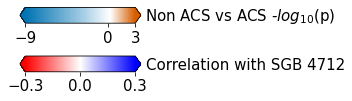

In [42]:
import matplotlib as mpl

tick_fontsize = 15
label_fontsize = 15

fig, axes = plt.subplots(2, 1, figsize=(5, 1.5))

ax = axes[0]
norm1 = MidpointNormalize(vmin=-9, 
                          vmax=3, 
                          midpoint=-2.5)
cmap1 = _get_scale_colors([cm_healthy, cm_acs], df_temp['Healthy-ACS'], return_cmap=True, boundries=[-9, 3])
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap1,
                                norm=norm1, ticks=[-9, 0, 3],
                                orientation='horizontal', extend='both')
# cb1.set_label('Healthy-ACS ($log_{10}$ pvalue)', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
# cb1.ax.set_xticks([-9, 0, 3]) 
# cb1.ax.set_xticklabels([-9, 0, 3]) 
ax.text(4, -7, 'Non ACS vs ACS -$log_{10}$(p)', fontsize=label_fontsize)

ax = axes[1]
norm1 = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.bwr_r,
                                norm=norm1, ticks=[-0.3, 0, 0.3], 
                                orientation='horizontal', extend='both')
# cb1.set_label('Microbiome $R^2$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
ax.text(0.3 * 1.2, -0.2, 'Correlation with SGB 4712', fontsize=label_fontsize)

fig.tight_layout()
plt.savefig(os.path.join(curr_dir, 'legend.png'), dpi=300)
# plt.savefig(os.path.join(curr_dir, 'legend.png'), dpi=800)